In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        out += identity
        return self.relu(out)


In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
def resnet18(num_classes=2):
    return ResNet(ResidualBlock, [2, 2, 2, 2], num_classes)


In [ ]:
import numpy as np

# Assuming mfcc_features is a NumPy array of shape (91, 52)
mfcc_features = np.random.rand(91, 52).astype(np.float32)

# Convert to a PyTorch tensor and add batch and channel dimensions
import torch
input_tensor = torch.tensor(mfcc_features).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 91, 52)


In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torch
import os

class MFCCDataset(Dataset):
    def __init__(self, file_paths):
        self.file_paths = file_paths

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = int(path.split("_")[-1].split(".")[0])  # 'patient_id_1.csv' → 1
        label = torch.tensor(label, dtype=torch.long)

        df = pd.read_csv(path, header=0)  # Skip header if exists
        features = df.iloc[:, 1:].values.astype(np.float32)  # Shape (91, 52)
        features = torch.tensor(features).unsqueeze(0)  # Add channel dim → (1, 91, 52)

        return features, label


In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Get all file paths
data_dir = "/content/drive/MyDrive/Normalized3/Final"
file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv")]

labels = [1 if "_1.csv" in f else 0 for f in file_paths]
train_paths, val_paths = train_test_split(file_paths, test_size=0.2, stratify=labels, random_state=42)

train_dataset = MFCCDataset(train_paths)
val_dataset = MFCCDataset(val_paths)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)               //Batch Size
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)                          //Optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


Epoch [1/150], Train Loss: 0.9916, Val Loss: 0.7100
Epoch [2/150], Train Loss: 0.7210, Val Loss: 0.7689
Epoch [3/150], Train Loss: 0.5962, Val Loss: 1.5870
Epoch [4/150], Train Loss: 0.6880, Val Loss: 0.7947
Epoch [5/150], Train Loss: 0.6179, Val Loss: 0.8629
Epoch [6/150], Train Loss: 0.6242, Val Loss: 1.2143
Epoch [7/150], Train Loss: 0.4902, Val Loss: 1.2052
Epoch [8/150], Train Loss: 0.4763, Val Loss: 1.7789
Epoch [9/150], Train Loss: 0.4512, Val Loss: 1.2928
Epoch [10/150], Train Loss: 0.4749, Val Loss: 2.4286
Epoch [11/150], Train Loss: 0.4458, Val Loss: 1.1767
Epoch [12/150], Train Loss: 0.3770, Val Loss: 1.6463
Epoch [13/150], Train Loss: 0.3314, Val Loss: 1.6582
Epoch [14/150], Train Loss: 0.2891, Val Loss: 1.7303
Epoch [15/150], Train Loss: 0.3278, Val Loss: 1.5768
Epoch [16/150], Train Loss: 0.2778, Val Loss: 0.8232
Epoch [17/150], Train Loss: 0.2535, Val Loss: 1.2105
Epoch [18/150], Train Loss: 0.3117, Val Loss: 1.4065
Epoch [19/150], Train Loss: 0.2737, Val Loss: 0.9461
Ep

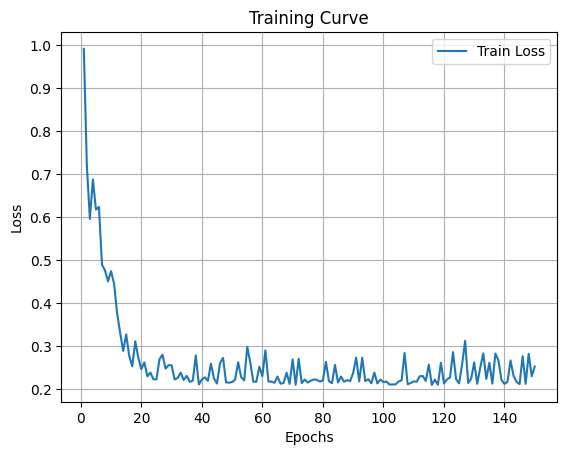

Model saved to /content/drive/MyDrive/stacking_preds/resnet_final.pkl
Predictions saved to /content/drive/MyDrive/stacking_preds/resnet_preds.pkl


In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch
from torch.utils.data import DataLoader

train_losses = []
val_losses = []
num_epochs = 150

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plotting the training loss curve
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.legend()
plt.grid()
plt.show()



# Save trained model
model_path = "/content/drive/MyDrive/stacking_preds/resnet_final.pkl"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Load trained model for prediction
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Load test dataset (All 164 patients)
test_dataset = MFCCDataset(file_paths)  # file_paths should have all normalized2/final paths
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Generate and save predictions
all_preds = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())

# Save as pickle file
output_path = "/content/drive/MyDrive/stacking_preds/resnet_preds.pkl"
with open(output_path, 'wb') as f:
    pickle.dump(np.array(all_preds), f)

print(f"Predictions saved to {output_path}")


In [ ]:
from torchsummary import summary

summary(model, input_size=(1, 91, 52))  # Assuming your input tensor shape is (1, 91, 52)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 46, 26]           3,136
       BatchNorm2d-2           [-1, 64, 46, 26]             128
              ReLU-3           [-1, 64, 46, 26]               0
         MaxPool2d-4           [-1, 64, 23, 13]               0
            Conv2d-5           [-1, 64, 23, 13]          36,864
       BatchNorm2d-6           [-1, 64, 23, 13]             128
              ReLU-7           [-1, 64, 23, 13]               0
            Conv2d-8           [-1, 64, 23, 13]          36,864
       BatchNorm2d-9           [-1, 64, 23, 13]             128
             ReLU-10           [-1, 64, 23, 13]               0
    ResidualBlock-11           [-1, 64, 23, 13]               0
           Conv2d-12           [-1, 64, 23, 13]          36,864
      BatchNorm2d-13           [-1, 64, 23, 13]             128
             ReLU-14           [-1, 64,

In [ ]:
from fvcore.nn import FlopCountAnalysis

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the correct device
input_tensor = torch.randn(1, 1, 91, 52).to(device)  # Input tensor with correct shape

# Calculate FLOPs
flops = FlopCountAnalysis(model, input_tensor)
print(f"FLOPs: {flops.total()}")


FLOPs: 193053440


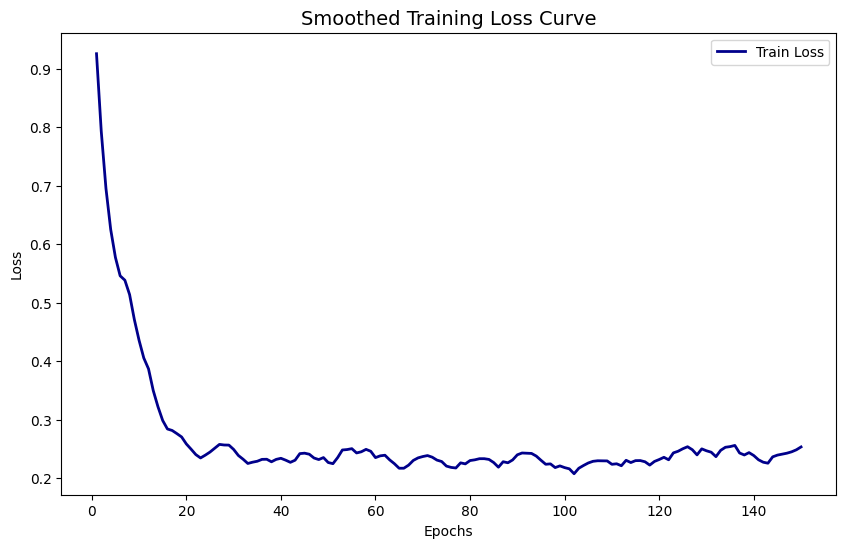

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter  # For smoothing

# Apply smoothing
smooth_train_losses = savgol_filter(train_losses, window_length=11, polyorder=3)

# Plotting the smoothed training loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), smooth_train_losses, label="Train Loss", color='darkblue', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Smoothed Training Loss Curve", fontsize=14)
plt.legend()
plt.show()


Accuracy: 0.9024390243902439
Confusion Matrix:
 [[79  8]
 [ 8 69]]
Classification Report:
               precision    recall  f1-score   support

           0     0.9080    0.9080    0.9080        87
           1     0.8961    0.8961    0.8961        77

    accuracy                         0.9024       164
   macro avg     0.9021    0.9021    0.9021       164
weighted avg     0.9024    0.9024    0.9024       164



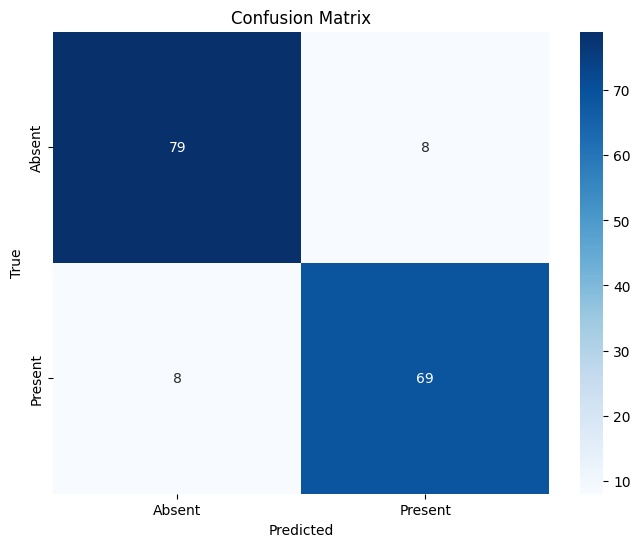

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

all_preds, all_labels = [], []
for inputs, labels in DataLoader(MFCCDataset(file_paths), batch_size=16, shuffle=False):
    inputs = inputs.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, digits=4)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Visualize the confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Absent', 'Present'], yticklabels=['Absent', 'Present'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
